# Human Emotion Recognition

## Libraries

In [2]:
import wandb
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomContrast,Rescaling,Resizing,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense,Input,RandomZoom,RandomBrightness,Activation,LeakyReLU,ReLU,Lambda,Add,Concatenate
from tensorflow.keras.callbacks import CSVLogger,ReduceLROnPlateau,EarlyStopping,Callback
from wandb.integration.keras import WandbCallback
from tensorflow.keras.layers import GaussianNoise
import random
import pandas as pd
import os

ModuleNotFoundError: No module named 'ace_tools'

In [44]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Dataset

### Class names and Paths

In [45]:
train_directory = "C:/Users/Dev/BallClash/TraningData/archive/train"
val_directory = "C:/Users/Dev/BallClash/TraningData/archive/test"
CLASS_NAMES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
BATCH_SIZE = 32

In [46]:

print("GPU Cihazları:", tf.config.list_physical_devices('GPU'))
wandb.init()

GPU Cihazları: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


accuracy,▂▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇
auc,▁▆▆▇▇▇▇▇▇▇▇█████████▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████
epoch,▁▁▂▂▂▃▃▃▄▄▅▆▆▆▆▇▇███▁▁▂▂▂▃▃▄▄▄▅▆▆▆▆▇▇▇██
loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁█▆▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂
precision,▁▆▆▇▇▇▇▇▇▇▇▇█████████▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇████
recall,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇█████▁▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇
top_2_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████▁▅▆▆▆▆▇▇▇▇▇▇▇▇██
top_k_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇███████▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
val_accuracy,▄▆▆▇▆██▇███████████▁▄▄▆▆▇▇▇▇███████▇████
val_auc,▅▆▅▇▇▇█▇███▇▇▇█▇█▇▁▁▅▅▆▆▆▆▇▇█▇█▇▇█▇██▇▇█
val_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▇▅▅▅▃▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂


In [47]:

MOBIL_CONFUGIRATION = {
    'MODEL_NAME':'mobilenet',
    'IM_SIZE':224,
    'WANDB':True,
    'CSV':True,
    'LR_REDUCE':False,
    'EARLY_STOPPING':True,
}
EFF_CONFUGIRATION = {
    'MODEL_NAME':'efficientnet',
    'IM_SIZE':380,
    'WANDB':True,
    'CSV':True,
    'LR_REDUCE':False,
    'EARLY_STOPPING':True,
}

In [48]:
def load_raw_data(training_dir,val_dir,config):
    try:
        training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            training_dir,
            labels='inferred',
            label_mode='categorical',
            class_names=CLASS_NAMES,
            color_mode='grayscale',
            batch_size=BATCH_SIZE,
            image_size=(config['IM_SIZE'],config['IM_SIZE']),
            shuffle=True,
            seed=99,
        )
        validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            val_dir,
            labels='inferred',
            label_mode='categorical',
            class_names=CLASS_NAMES,
            color_mode='grayscale',
            batch_size=BATCH_SIZE,
            image_size=(config['IM_SIZE'],config['IM_SIZE']),
            shuffle=True,
            seed=99,

        )
        return training_dataset,validation_dataset
    except Exception as e:
        print(f"Error loading data: {e}")
        raise e

## Augmentation and Data Preprocessing

In [49]:
AUGMENTATION_V1 = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(factor=(-0.1, 0.1)),  
    RandomContrast(factor=0.1),
    RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),  
    RandomBrightness(factor=0.1),
])

AUGMENTATION_V2 = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(factor=(-0.1, 0.1)),  
])

def augmentation(image,label,layer):
    return layer(image,training=True),label

In [50]:
def apply_augmentation_and_prefetch(training_dataset, validation_dataset,config=None):
    print("Augmentation is applied")
    training_dataset = (
            training_dataset
            .map(lambda x, y: augmentation(x, y, config['AUGMENTATION']), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )
    validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
    
    return training_dataset, validation_dataset



In [51]:
def prepare_datasets(config):
    train_ds, val_ds = load_raw_data(train_directory, val_directory, config)
    train_ds, val_ds = apply_augmentation_and_prefetch(train_ds, val_ds,config=config)
    return train_ds, val_ds


In [52]:
def resize_rescale(model_name, config):
    resize_rescale_layer = tf.keras.Sequential([
            Resizing(config["IM_SIZE"], config["IM_SIZE"]),
            Rescaling(1./255)
    ])
    return resize_rescale_layer


## Callbacks

In [53]:
class PrintBestMetric(Callback):
    def __init__(self, monitor='val_accuracy'):
        super(PrintBestMetric, self).__init__()
        self.monitor = monitor
        self.best = -float('inf') if 'acc' in monitor else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if ('acc' in self.monitor and current > self.best) or \
               ('loss' in self.monitor and current < self.best):
                self.best = current

    def on_train_end(self, logs=None):
        print(f"\n Best e {self.monitor}: {self.best:.4f}")

In [54]:
def get_callbacks(config):
    callbacks = []
    callbacks.append(PrintBestMetric(monitor='val_accuracy'))
    if config['WANDB']:
        callbacks.append(WandbCallback(save_model=False))
    if config['CSV']:
        callbacks.append(CSVLogger(f'logs/{config["CONFIG_NAME"]}.csv')) 
    if config['LR_REDUCE']:
        initial_learning_rate = config['LEARNING_RATE']
        decay_steps = 1000
        warmup_steps = 100 
        lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate,
            decay_steps,
            t_mul=2.0,
            m_mul=0.9,
            alpha=0.1
        )
        callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_schedule))
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5))
    if config['EARLY_STOPPING']:
        callbacks.append(EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True,verbose=1))
    return callbacks

In [55]:
def add_conv_layer(config, model):
    conv_filters = config['CONV_FILTERS']
    for idx, filters in enumerate(conv_filters):
        model.add(Conv2D(filters, (2, 2), strides=1, padding='same'))
        if config['ACTIVATION'] == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(config['ACTIVATION']))
        model.add(MaxPooling2D(pool_size=2))
        model.add(BatchNormalization())
        if idx != len(conv_filters) - 1:
            model.add(Dropout(config['DROPOUT_RATE']))
    return model

def add_neuron_layer(config, model):
    for units in config['DENSE_NUM']:
        model.add(Dense(units))
        if config['ACTIVATION'] == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(config['ACTIVATION']))
        model.add(BatchNormalization()) 
        model.add(Dropout(config['DROPOUT_RATE']))
    return model


In [56]:
def build_seq_model_compile(config):
    train_ds, val_ds = prepare_datasets(config)
    resize_rescale_layer = resize_rescale(model_name='seq', config=config)
    callbacks = get_callbacks(config)

    model = tf.keras.Sequential()
    model.add(Input(shape=(None, None, 1)))
    model.add(resize_rescale_layer)

    add_conv_layer(config, model)

    model.add(Flatten())

    add_neuron_layer(config, model)

    model.add(Dense(config['CLASSES'], activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_k_accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')],
        
    )


    return model,train_ds,val_ds,callbacks


In [57]:
def extract_model_and_info(model_name,config):
    if model_name == 'seq':
        model,train_ds,val_ds,callbacks = build_seq_model_compile(config=config)
    elif model_name == 'mobilenet':
        config = MOBIL_CONFUGIRATION
        model,train_ds,val_ds,callbacks = build_seq_model_compile(config=config) 
    elif model_name == 'efficientnet':
        config = EFF_CONFUGIRATION
        model,train_ds,val_ds,callbacks = build_seq_model_compile(config=config)  

    return model,train_ds,val_ds,callbacks

# 1. LEARNING RATE COMPARISON (with both activations)
LR_HIGH_RELU_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'LR_HIGH_RELU',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'relu',
    'AUGMENTATION': AUGMENTATION_V1
}

LR_HIGH_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'LR_HIGH_LEAKY',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}

LR_LOW_RELU_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'LR_LOW_RELU',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'relu',
    'AUGMENTATION': AUGMENTATION_V1
}

LR_LOW_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'LR_LOW_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}

# 2. DROPOUT IMPACT (with both activations)
DROPOUT_LOW_RELU_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'DROPOUT_LOW_RELU',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.3,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'relu',
    'AUGMENTATION': AUGMENTATION_V1
}

DROPOUT_LOW_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'DROPOUT_LOW_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.3,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}
DROPOUT_HIGH_RELU_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'DROPOUT_HIGH_RELU',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.5,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'relu',
    'AUGMENTATION': AUGMENTATION_V1
}

DROPOUT_HIGH_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'DROPOUT_HIGH_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.5,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}

# 3. ARCHITECTURE COMPARISON (with both activations)
SIMPLE_ARCH_RELU_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'SIMPLE_ARCH_RELU',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'relu',
    'AUGMENTATION': AUGMENTATION_V1
}

SIMPLE_ARCH_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'SIMPLE_ARCH_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}

# 4. AUGMENTATION STRATEGY (with both activations)
AUG_V1_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'AUG_V1_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1
}

AUG_V2_LEAKY_CONFIG = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'AUG_V2_LEAKY',
    'LEARNING_RATE': 0.0001,
    'DROPOUT_RATE': 0.4,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [512,128,32],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2
}
V2_EXP1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'V2_EXP1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

KAGGLE = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

NEW_STR_V2_CONV1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'NEW_STR_V2_CONV1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256,512],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

NEW_STR_V1_CONV1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'NEW_STR_V1_CONV1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256,512],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1,
    
}

NEW_STR_V1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'NEW_STR_V1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256,512],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V1,
    
}

KAGGLE = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [32,64,128,256],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

KAGGLE1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

KAGGLE2 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE2',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256],
    'DENSE_NUM': [1028,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}


In [60]:
# BASE CONFIGURATION
BASE_CONFIG = {
    'MODEL_NAME': 'seq',
    'IM_SIZE': 48,
    'EPOCHS': 50,
    'WANDB': True,
    'CSV': True,
    'LR_REDUCE': True,
    'EARLY_STOPPING': True,
    'CLASSES': len(CLASS_NAMES),
}





KAGGLE1 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE1',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256],
    'DENSE_NUM': [256,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}

KAGGLE2 = {
    **BASE_CONFIG,
    'CONFIG_NAME': 'KAGGLE2',
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.25,
    'CONV_FILTERS': [64,128,256],
    'DENSE_NUM': [1028,512],
    'ACTIVATION': 'leakyrelu',
    'AUGMENTATION': AUGMENTATION_V2,
    
}


ALL_CONFIGS = [
    KAGGLE1,KAGGLE2
]

In [61]:
for idx, config in enumerate(ALL_CONFIGS):
    model, train_ds, val_ds, callbacks = extract_model_and_info('seq', config)
    
    print(f'Running {idx+1}, {config["CONFIG_NAME"]}')
    print(f'Learning Rate: {config["LEARNING_RATE"]}')
    print(f'Dropout Rate: {config["DROPOUT_RATE"]}')
    print(f'Architecture: {config["CONV_FILTERS"]}')
    print(f'Activation: {config["ACTIVATION"]}')
    print(f'Augmentation: {config["AUGMENTATION"]}')
    print('-' * 50)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config['EPOCHS'],
        callbacks=callbacks,
        verbose=1
    )

Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.
Augmentation is applied
Running 1, KAGGLE1
Learning Rate: 0.001
Dropout Rate: 0.25
Architecture: [64, 128, 256]
Activation: leakyrelu
Augmentation: <keras.engine.sequential.Sequential object at 0x0000018C9883B490>
--------------------------------------------------
Epoch 1/50
1768/1768 [==============================] - 31s 17ms/step - loss: 1.8591 - accuracy: 0.2749 - top_k_accuracy: 0.4681 - top_2_accuracy: 0.4681 - precision: 0.3581 - recall: 0.0846 - auc: 0.6219 - val_loss: 1.5347 - val_accuracy: 0.3985 - val_top_k_accuracy: 0.5871 - val_top_2_accuracy: 0.5871 - val_precision: 0.5847 - val_recall: 0.2403 - val_auc: 0.7513 - lr: 0.0010
Epoch 2/50
1768/1768 [==============================] - 27s 16ms/step - loss: 1.5135 - accuracy: 0.4015 - top_k_accuracy: 0.6028 - top_2_accuracy: 0.6028 - precision: 0.6179 - recall: 0.1932 - auc: 0.7492 - val_loss: 1.4400 - val_accuracy: 0.4616 - val_top_k_accuracy: 0.

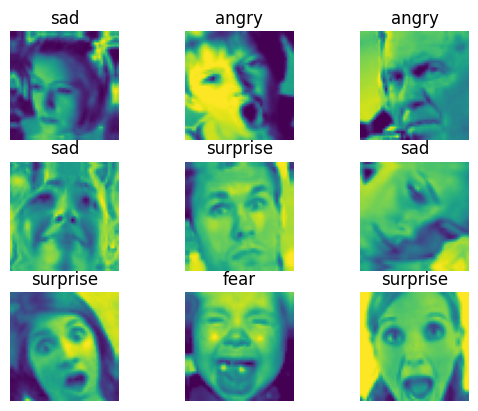

In [38]:
i = 0
for image, label in train_ds.take(9):
    ax = plt.subplot(3, 3, i+1)
    # Select first image from the batch and convert to uint8
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[np.argmax(label[0])])
    plt.axis('off')
    i += 1
plt.show()

## Visualize Model Results

In [6]:
path = "experiment_logs"

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

csv_datas = []

for file in csv_files:
    full_path = os.path.join(path,file)
    df = pd.read_csv(full_path)
    csv_datas.append((file,df))


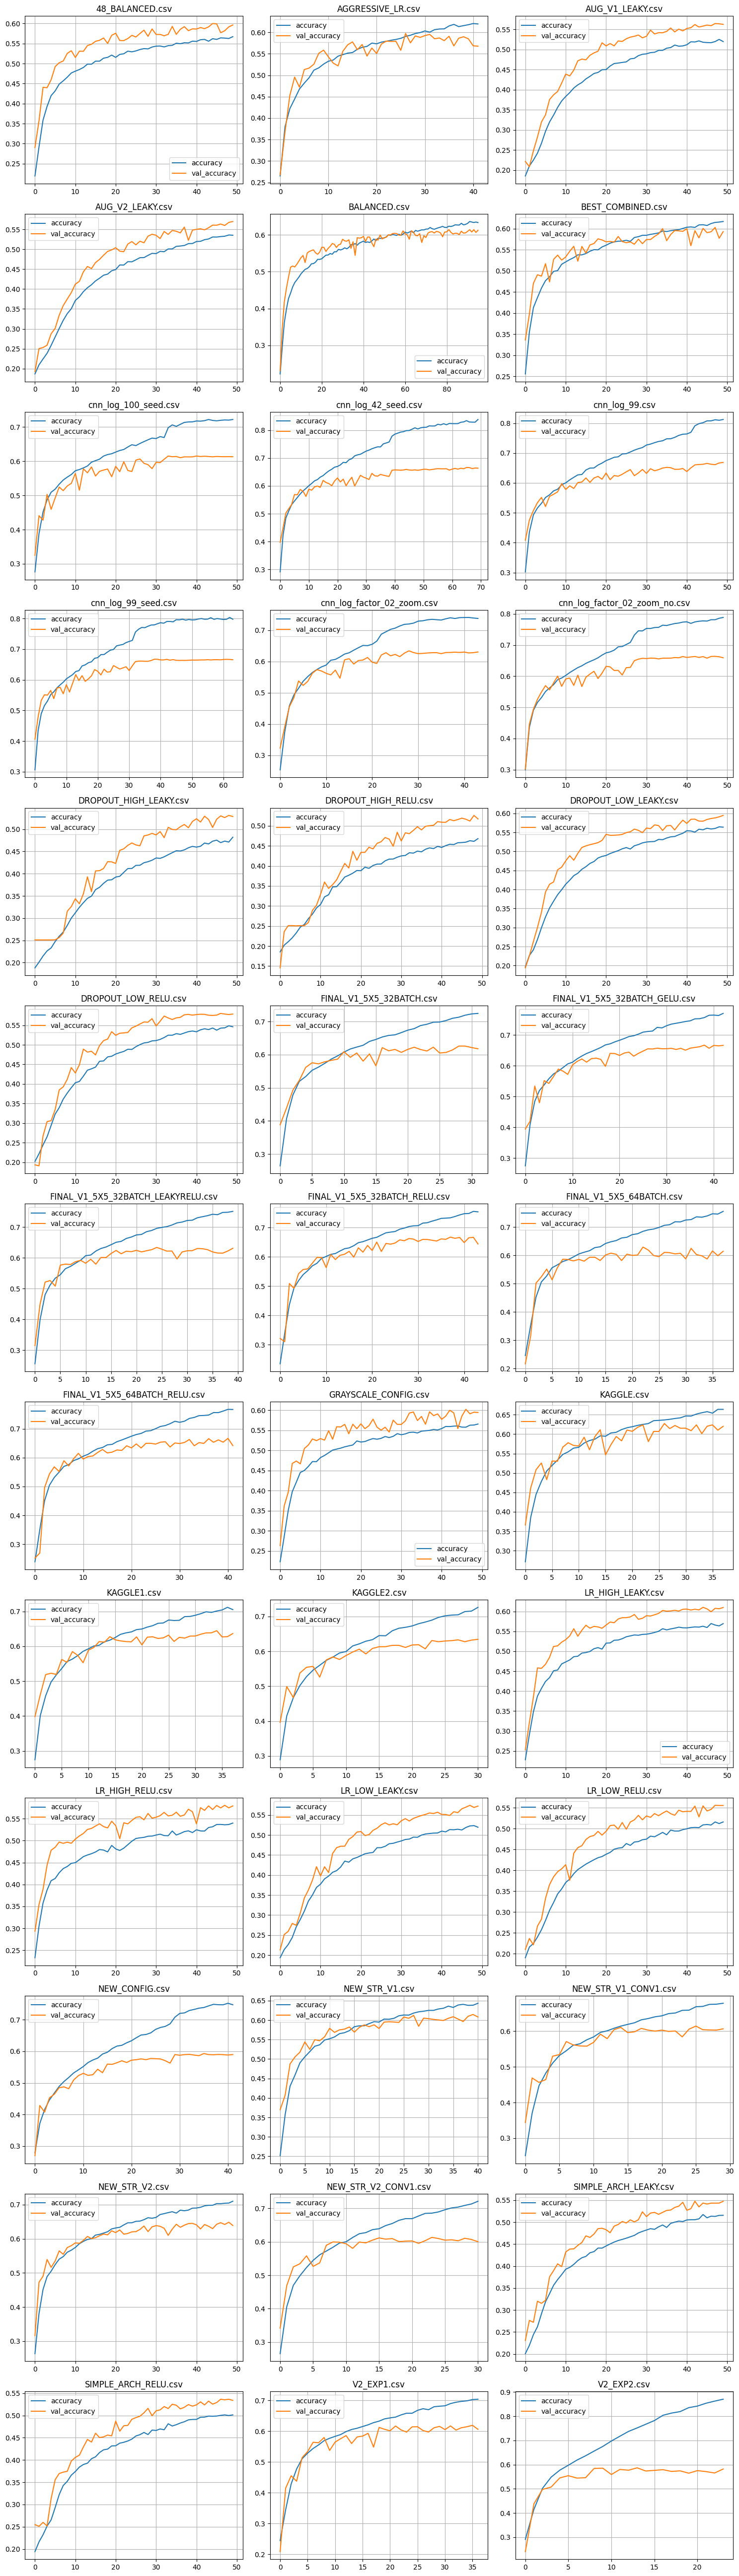

In [7]:
def visualize_model_results(csv_datas,train_metric='accuracy',val_metric='val_accuracy'):
    # Calculate the number of rows and columns for subplots
    n_plots = len(csv_datas)
    n_cols = min(3, n_plots)  # Maximum 3 plots per row
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Flatten axes array for easier indexing
    if n_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each model's results
    for idx, (file, df) in enumerate(csv_datas):
        ax = axes[idx]
        ax.plot(df[train_metric], label=train_metric)
        ax.plot(df[val_metric], label=val_metric)
        ax.set_title(f'{file}')
        ax.legend()
        ax.grid(True)
    
    # Hide empty subplots if any
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show() 
visualize_model_results(csv_datas,train_metric='accuracy',val_metric='val_accuracy')

In [8]:
def top_k_performance(csv_datas, k=5):
    keys = ['val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'val_top_k_accuracy']
    top_performance = {}

    for key in keys:
        key_values = []

        for file, data in csv_datas:
            if key in data.columns:
                if key == 'val_loss':
                    current_value = data[key].min()
                else:
                    current_value = data[key].max()
                key_values.append((file, current_value))

        if key_values:
            if key == 'val_loss':
                sorted_values = sorted(key_values, key=lambda x: x[1])
            else:
                sorted_values = sorted(key_values, key=lambda x: x[1], reverse=True)

            top_performance[key] = sorted_values[:k]
        else:
            top_performance[key] = [("No data available", None)]

    return top_performance
top_k_results = top_k_performance(csv_datas, k=5)
top_k_results

{'val_accuracy': [('cnn_log_99.csv', 0.6684590578079224),
  ('FINAL_V1_5X5_32BATCH_RELU.csv', 0.6676099896430969),
  ('cnn_log_99_seed.csv', 0.6670439839363098),
  ('FINAL_V1_5X5_32BATCH_GELU.csv', 0.6670439839363098),
  ('FINAL_V1_5X5_64BATCH_RELU.csv', 0.6670439839363098)],
 'val_auc': [('FINAL_V1_5X5_32BATCH_RELU.csv', 0.9161465167999268),
  ('FINAL_V1_5X5_32BATCH_GELU.csv', 0.9139047861099244),
  ('cnn_log_99_seed.csv', 0.9131696224212646),
  ('FINAL_V1_5X5_64BATCH_RELU.csv', 0.9131478667259216),
  ('cnn_log_factor_02_zoom_no.csv', 0.9128103852272034)],
 'val_loss': [('FINAL_V1_5X5_32BATCH_RELU.csv', 0.9492698311805724),
  ('FINAL_V1_5X5_32BATCH_GELU.csv', 0.967356026172638),
  ('FINAL_V1_5X5_64BATCH_RELU.csv', 0.9723699688911438),
  ('cnn_log_factor_02_zoom_no.csv', 0.9890933632850648),
  ('cnn_log_99_seed.csv', 0.999995231628418)],
 'val_precision': [('BALANCED.csv', 0.7862494587898254),
  ('48_BALANCED.csv', 0.785029947757721),
  ('GRAYSCALE_CONFIG.csv', 0.7707991003990173),
  (

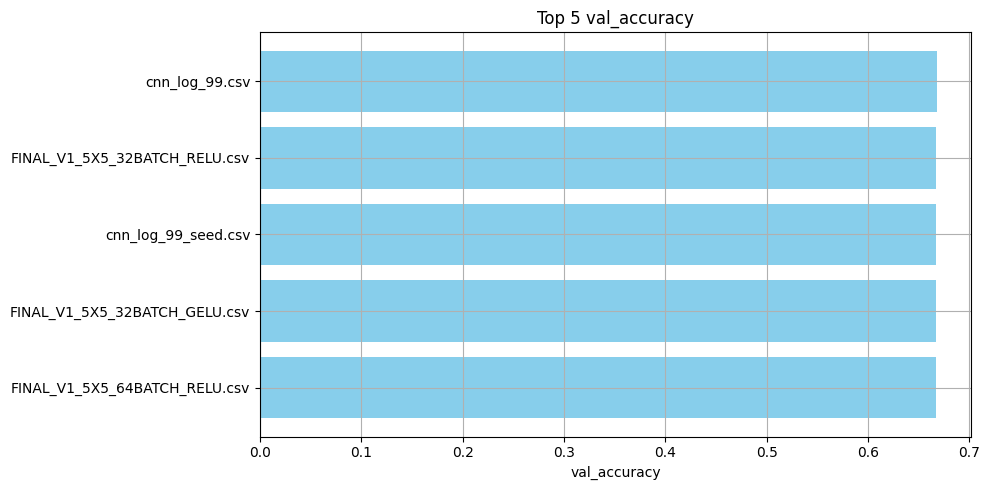

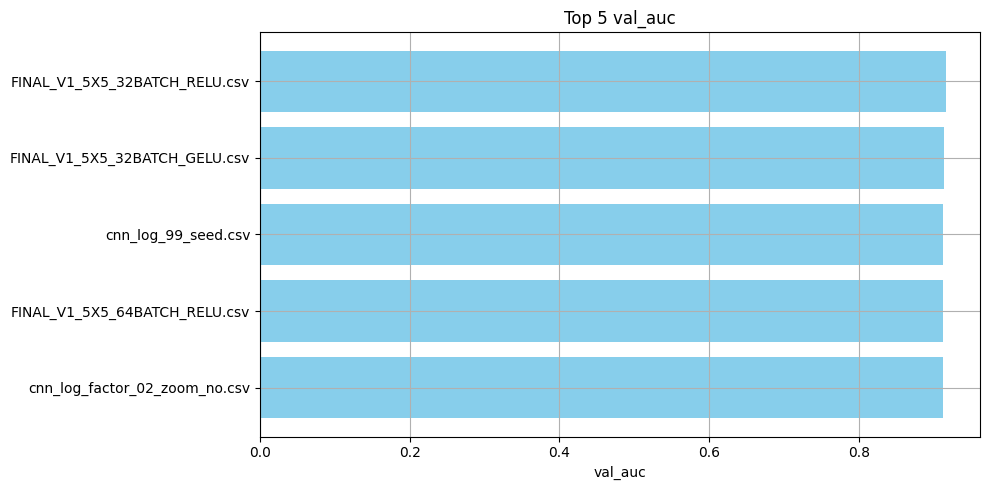

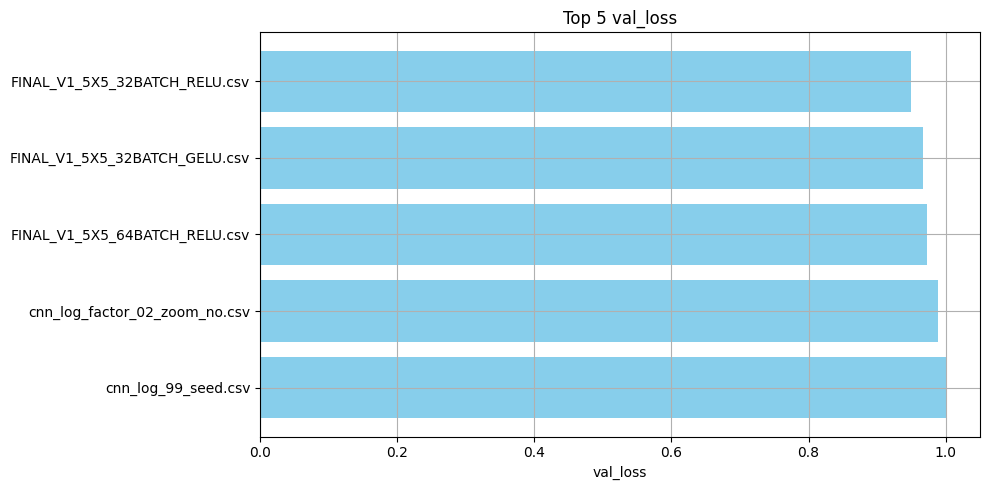

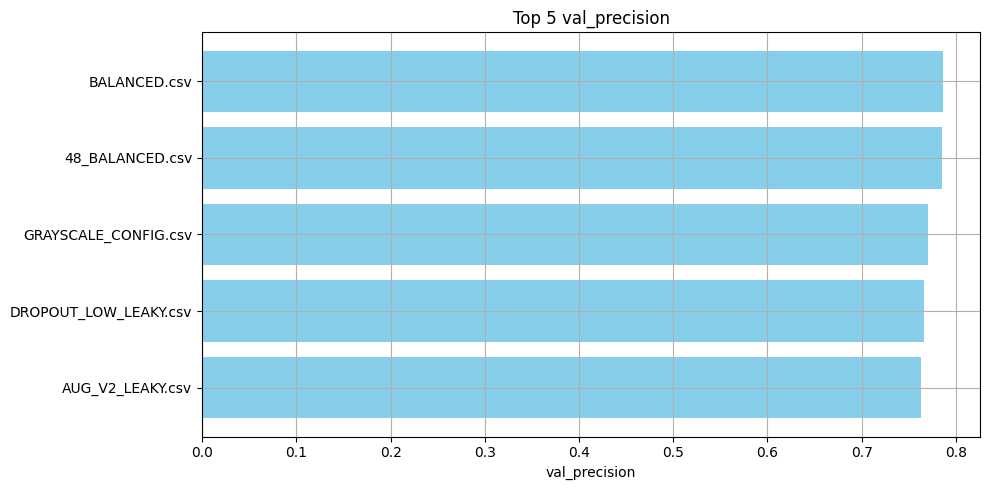

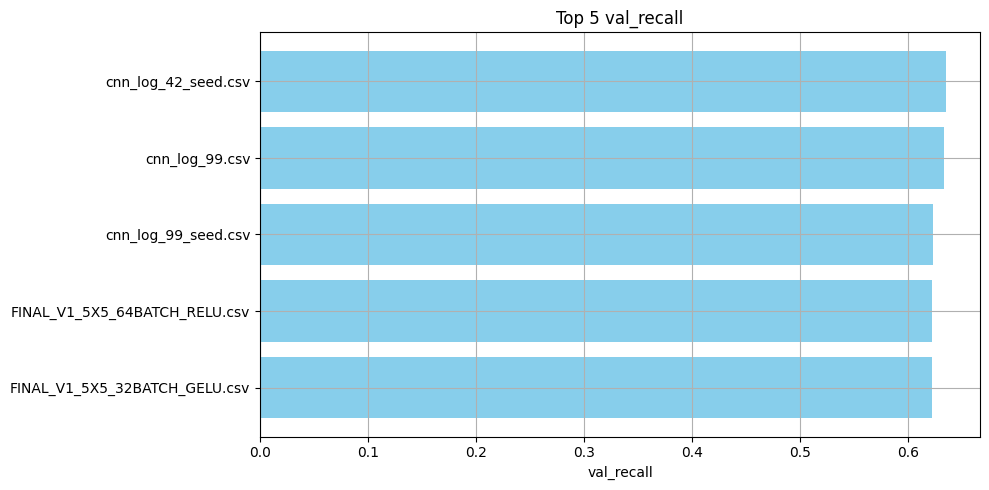

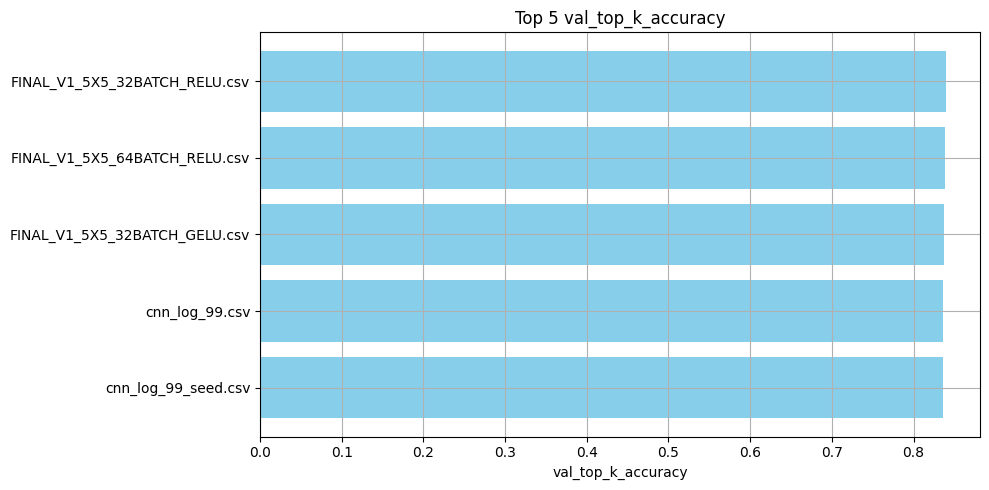

In [10]:
for metric, results in top_k_results.items():
    files, scores = zip(*results)
    plt.figure(figsize=(10, 5))
    plt.barh(files, scores, color='skyblue')
    plt.xlabel(metric)
    plt.title(f'Top 5 {metric}')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
df_dict = {}
for metric, records in top_k_results.items():
    df = pd.DataFrame(records, columns=['File Name', metric])
    df_dict[metric] = df

In [15]:
import IPython.display as display
for metric, df in df_dict.items():
    print(f"\nTop 5 results for: {metric}")
    display.display(df)


Top 5 results for: val_accuracy


,File Name,val_accuracy
0,cnn_log_99.csv,0.668459
1,FINAL_V1_5X5_32BATCH_RELU.csv,0.667610
2,cnn_log_99_seed.csv,0.667044
3,FINAL_V1_5X5_32BATCH_GELU.csv,0.667044
4,FINAL_V1_5X5_64BATCH_RELU.csv,0.667044



Top 5 results for: val_auc


,File Name,val_auc
0,FINAL_V1_5X5_32BATCH_RELU.csv,0.916147
1,FINAL_V1_5X5_32BATCH_GELU.csv,0.913905
2,cnn_log_99_seed.csv,0.913170
3,FINAL_V1_5X5_64BATCH_RELU.csv,0.913148
4,cnn_log_factor_02_zoom_no.csv,0.912810



Top 5 results for: val_loss


,File Name,val_loss
0,FINAL_V1_5X5_32BATCH_RELU.csv,0.949270
1,FINAL_V1_5X5_32BATCH_GELU.csv,0.967356
2,FINAL_V1_5X5_64BATCH_RELU.csv,0.972370
3,cnn_log_factor_02_zoom_no.csv,0.989093
4,cnn_log_99_seed.csv,0.999995



Top 5 results for: val_precision


,File Name,val_precision
0,BALANCED.csv,0.786249
1,48_BALANCED.csv,0.785030
2,GRAYSCALE_CONFIG.csv,0.770799
3,DROPOUT_LOW_LEAKY.csv,0.766551
4,AUG_V2_LEAKY.csv,0.763014



Top 5 results for: val_recall


,File Name,val_recall
0,cnn_log_42_seed.csv,0.635064
1,cnn_log_99.csv,0.633083
2,cnn_log_99_seed.csv,0.623178
3,FINAL_V1_5X5_64BATCH_RELU.csv,0.622612
4,FINAL_V1_5X5_32BATCH_GELU.csv,0.622471



Top 5 results for: val_top_k_accuracy


,File Name,val_top_k_accuracy
0,FINAL_V1_5X5_32BATCH_RELU.csv,0.839394
1,FINAL_V1_5X5_64BATCH_RELU.csv,0.838687
2,FINAL_V1_5X5_32BATCH_GELU.csv,0.837130
3,cnn_log_99.csv,0.836140
4,cnn_log_99_seed.csv,0.836140
